# Direction Selectivity and Motion Processing in V1

## Overview

In this notebook, we'll explore how primary visual cortex (V1) neurons detect and represent motion. Building on our previous understanding of receptive fields and the distinction between simple and complex cells, we'll now examine how V1 neurons develop direction selectivity – a crucial step in the visual motion processing pathway.

Topics we'll cover:
- Direction selectivity in V1 neurons
- The difference between orientation tuning and direction tuning
- Spatiotemporal receptive fields and their inseparability
- How space-time inseparable filters detect motion
- The aperture problem and its implications for motion perception

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
import matplotlib.cm as cm
from IPython.display import HTML

# Set some plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## Direction Selectivity in V1

While many V1 neurons respond to oriented stimuli like bars or edges regardless of their direction of motion (orientation selectivity), some V1 neurons respond preferentially when a stimulus moves in a particular direction (direction selectivity).

A direction-selective neuron might respond strongly to a vertical bar moving rightward but weakly or not at all to the same bar moving leftward. This represents a fundamental computation in the visual system: extracting motion information from the changing pattern of light on the retina.

### Orientation vs. Direction Tuning

To understand direction selectivity, we first need to clarify the relationship between orientation tuning and direction tuning:

- **Orientation tuning**: A neuron responds to a specific edge orientation regardless of motion direction. For example, a vertical orientation-tuned neuron responds equally to a vertical bar moving right or left.

- **Direction tuning**: A neuron responds preferentially to motion in a specific direction. For example, a rightward direction-tuned neuron responds strongly to rightward motion but weakly to leftward motion.

Let's visualize the difference between these two types of tuning:

In [ ]:
def plot_tuning_curves():
    # Create orientation angles (0-180 degrees)
    orientations = np.linspace(0, 180, 37)[:-1]
    
    # Create direction angles (0-360 degrees)
    directions = np.linspace(0, 360, 73)[:-1]
    
    # Create an orientation-tuned response (peaks at 90 degrees - vertical orientation)
    orientation_response = np.exp(-0.5 * ((orientations - 90) / 15) ** 2)
    
    # Create a direction-tuned response (peaks at 0 degrees - rightward motion)
    direction_response = np.exp(-0.5 * ((directions - 0) / 30) ** 2) + \
                         0.1 * np.exp(-0.5 * ((directions - 180) / 30) ** 2)  # Small response to opposite direction
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': 'polar'})
    
    # Plot orientation tuning (map 0-180 to 0-360 for polar plot)
    orientation_plot = np.concatenate([orientation_response, orientation_response])
    orientation_angles = np.deg2rad(np.concatenate([orientations, orientations+180]))
    ax1.plot(orientation_angles, orientation_plot, 'b-')
    ax1.fill(orientation_angles, orientation_plot, alpha=0.2)
    ax1.set_title('Orientation Tuning (non-directional)', fontsize=14)
    ax1.set_rticks([0.5, 1.0])
    ax1.set_rlabel_position(45)
    ax1.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))
    ax1.set_xticklabels(['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'])
    
    # Plot direction tuning
    direction_angles = np.deg2rad(directions)
    ax2.plot(direction_angles, direction_response, 'r-')
    ax2.fill(direction_angles, direction_response, alpha=0.2)
    ax2.set_title('Direction Tuning (rightward preferred)', fontsize=14)
    ax2.set_rticks([0.5, 1.0])
    ax2.set_rlabel_position(45)
    ax2.set_xticks(np.deg2rad([0, 45, 90, 135, 180, 225, 270, 315]))
    ax2.set_xticklabels(['0°', '45°', '90°', '135°', '180°', '225°', '270°', '315°'])
    
    plt.tight_layout()
    plt.show()
    
    # Also show a diagram to help interpret
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Schematic for orientation tuning
    ax1.set_xlim(-5, 5)
    ax1.set_ylim(-5, 5)
    ax1.set_aspect('equal')
    ax1.set_title('Orientation-Selective Neuron\n(responds to vertical, any direction)', fontsize=14)
    ax1.add_patch(plt.Rectangle((-4, -0.2), 8, 0.4, color='black'))
    ax1.arrow(-3, 0, 1, 0, head_width=0.4, head_length=0.3, fc='blue', ec='blue')
    ax1.arrow(3, 0, -1, 0, head_width=0.4, head_length=0.3, fc='blue', ec='blue')
    ax1.text(-3, 1, 'Equal Response', color='blue', fontsize=12)
    ax1.text(1, 1, 'Equal Response', color='blue', fontsize=12)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # Schematic for direction tuning
    ax2.set_xlim(-5, 5)
    ax2.set_ylim(-5, 5)
    ax2.set_aspect('equal')
    ax2.set_title('Direction-Selective Neuron\n(responds to rightward motion)', fontsize=14)
    ax2.add_patch(plt.Rectangle((-4, -0.2), 8, 0.4, color='black'))
    ax2.arrow(-3, 0, 1, 0, head_width=0.4, head_length=0.3, fc='red', ec='red')
    ax2.arrow(3, 0, -1, 0, head_width=0.4, head_length=0.3, fc='gray', ec='gray', alpha=0.5)
    ax2.text(-3, 1, 'Strong Response', color='red', fontsize=12)
    ax2.text(1, 1, 'Weak/No Response', color='gray', fontsize=12)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    plt.tight_layout()
    plt.show()

plot_tuning_curves()

Approximately 30% of V1 neurons show direction selectivity, particularly in layer 4B, which projects to the middle temporal area (MT/V5) - a region specialized for motion processing that we'll explore in a later section.

## Spatiotemporal Receptive Fields

To understand how V1 neurons achieve direction selectivity, we need to consider their receptive fields in both space and time. These spatiotemporal receptive fields describe how a neuron responds to stimuli at different positions in the visual field and at different time points.

### Space-Time Separability and Inseparability

A key concept for understanding direction selectivity is whether a spatiotemporal receptive field is separable or inseparable:

- **Separable receptive field**: Can be expressed as the product of separate spatial and temporal components. A separable receptive field has the same spatial profile at each time point, just scaled by the temporal response. These do not exhibit direction selectivity.

- **Inseparable receptive field**: Cannot be decomposed into separate spatial and temporal components. The spatial profile changes shape over time in a specific way. These can exhibit direction selectivity.

Let's visualize both types of receptive fields:

In [ ]:
def create_spatiotemporal_rfs():
    # Parameters
    x = np.linspace(-10, 10, 100)  # Spatial dimension
    t = np.linspace(0, 10, 50)      # Temporal dimension
    
    # Create meshgrid for visualization
    X, T = np.meshgrid(x, t)
    
    # Spatial component (Gabor-like function)
    sigma_x = 2.0
    spatial = np.exp(-X**2 / (2*sigma_x**2)) * np.cos(2*np.pi*0.3*X)
    
    # Temporal component (biphasic function)
    sigma_t = 1.0
    alpha = 0.3
    temporal = (1 - alpha*T) * np.exp(-T**2 / (2*sigma_t**2))
    
    # Separable receptive field (product of spatial and temporal components)
    separable_rf = spatial * temporal[:, np.newaxis]
    
    # Inseparable receptive field (spatiotemporal tilt introduces direction selectivity)
    velocity = 1.0  # Preferred velocity
    X_moved = X - velocity * T  # Tilted space-time coordinates
    spatial_moved = np.exp(-X_moved**2 / (2*sigma_x**2)) * np.cos(2*np.pi*0.3*X_moved)
    inseparable_rf = spatial_moved * temporal[:, np.newaxis]
    
    return x, t, separable_rf, inseparable_rf

def plot_spatiotemporal_rfs():
    x, t, separable_rf, inseparable_rf = create_spatiotemporal_rfs()
    
    # Plot as heatmaps (space-time plots)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    img1 = ax1.imshow(separable_rf, aspect='auto', cmap='RdBu_r', 
                      extent=[x.min(), x.max(), t.max(), t.min()],
                      vmin=-np.abs(separable_rf).max(), vmax=np.abs(separable_rf).max())
    ax1.set_title('Space-Time Separable RF\n(Non-Direction Selective)', fontsize=14)
    ax1.set_xlabel('Space (x)', fontsize=12)
    ax1.set_ylabel('Time (t)', fontsize=12)
    ax1.grid(False)
    
    # Add a right-moving stimulus trajectory
    ax1.plot([-8, 8], [10, 0], 'w--', alpha=0.7, linewidth=2, label='Rightward motion')
    # Add a left-moving stimulus trajectory
    ax1.plot([8, -8], [10, 0], 'w:', alpha=0.7, linewidth=2, label='Leftward motion')
    ax1.legend(loc='upper center', framealpha=0.8)
    
    img2 = ax2.imshow(inseparable_rf, aspect='auto', cmap='RdBu_r', 
                      extent=[x.min(), x.max(), t.max(), t.min()],
                      vmin=-np.abs(inseparable_rf).max(), vmax=np.abs(inseparable_rf).max())
    ax2.set_title('Space-Time Inseparable RF\n(Direction Selective to Rightward Motion)', fontsize=14)
    ax2.set_xlabel('Space (x)', fontsize=12)
    ax2.set_ylabel('Time (t)', fontsize=12)
    ax2.grid(False)
    
    # Add a right-moving stimulus trajectory that aligns with the tilted RF
    ax2.plot([-8, 8], [10, 0], 'w--', alpha=0.7, linewidth=2, label='Rightward motion (preferred)')
    # Add a left-moving stimulus trajectory
    ax2.plot([8, -8], [10, 0], 'w:', alpha=0.7, linewidth=2, label='Leftward motion')
    ax2.legend(loc='upper center', framealpha=0.8)
    
    # Add colorbars
    fig.colorbar(img1, ax=ax1, shrink=0.7)
    fig.colorbar(img2, ax=ax2, shrink=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Now show some example temporal slices of the inseparable RF
    plt.figure(figsize=(12, 5))
    
    # Select a few time points
    time_indices = [0, 10, 20, 30, 40]
    time_values = t[time_indices]
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_indices)))
    
    for i, (idx, color) in enumerate(zip(time_indices, colors)):
        plt.plot(x, inseparable_rf[idx], color=color, 
                 label=f't = {time_values[i]:.1f}', linewidth=2)
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.title('Spatial Profile of Direction-Selective RF at Different Time Points', fontsize=14)
    plt.xlabel('Space (x)', fontsize=12)
    plt.ylabel('Response', fontsize=12)
    plt.legend(title='Time')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_spatiotemporal_rfs()

### Key Observations

In the space-time plots above:

1. The separable RF has a consistent pattern of alternating excitatory (red) and inhibitory (blue) regions that don't change shape over time, just amplitude. It responds equally to both rightward and leftward motion.

2. The inseparable RF has a slanted or tilted pattern in space-time. This tilt means that the spatial profile shifts over time, creating a preferred direction. The white dashed line (rightward motion) aligns with the tilted RF structure, resulting in strong activation.

3. In the bottom plot, we can see how the spatial profile of the inseparable RF changes over time - essentially "shifting" to the right, which means it will respond strongly to rightward motion.

## How Inseparable Filters Detect Motion

To understand more intuitively how an inseparable receptive field creates direction selectivity, let's visualize what happens when a moving stimulus passes through such a receptive field.

First, let's create a function to generate a moving edge stimulus:

In [ ]:
def generate_moving_edge(x, t, velocity, direction=1):
    '''Generate a moving edge in spatiotemporal coordinates'''
    # Create a spatiotemporal stimulus array
    X, T = np.meshgrid(x, t)
    
    # Position of edge at each time point
    edge_position = direction * velocity * T
    
    # Create binary edge stimulus (1 where X > edge_position, 0 elsewhere)
    stimulus = (X > edge_position).astype(float)
    
    return stimulus

def compute_response(stimulus, receptive_field):
    '''Compute response of a receptive field to a stimulus'''
    # Element-wise multiplication and summation
    response = np.sum(stimulus * receptive_field)
    return response

def visualize_motion_detection():
    # Get our spatiotemporal RFs
    x, t, separable_rf, inseparable_rf = create_spatiotemporal_rfs()
    
    # Generate moving edge stimuli in both directions
    velocity = 1.5
    rightward_edge = generate_moving_edge(x, t, velocity, direction=1)
    leftward_edge = generate_moving_edge(x, t, velocity, direction=-1)
    
    # Plot the stimuli and RFs
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    
    # Plot rightward stimulus
    axs[0, 0].imshow(rightward_edge, cmap='gray', aspect='auto',
                     extent=[x.min(), x.max(), t.max(), t.min()])
    axs[0, 0].set_title('Rightward Moving Edge')
    axs[0, 0].set_xlabel('Space (x)')
    axs[0, 0].set_ylabel('Time (t)')
    
    # Plot leftward stimulus
    axs[1, 0].imshow(leftward_edge, cmap='gray', aspect='auto',
                     extent=[x.min(), x.max(), t.max(), t.min()])
    axs[1, 0].set_title('Leftward Moving Edge')
    axs[1, 0].set_xlabel('Space (x)')
    axs[1, 0].set_ylabel('Time (t)')
    
    # Plot separable RF
    im1 = axs[0, 1].imshow(separable_rf, cmap='RdBu_r', aspect='auto',
                           extent=[x.min(), x.max(), t.max(), t.min()],
                           vmin=-np.abs(separable_rf).max(), vmax=np.abs(separable_rf).max())
    axs[0, 1].set_title('Separable RF')
    axs[0, 1].set_xlabel('Space (x)')
    axs[0, 1].set_ylabel('Time (t)')
    fig.colorbar(im1, ax=axs[0, 1], shrink=0.7)
    
    # Plot inseparable RF
    im2 = axs[1, 1].imshow(inseparable_rf, cmap='RdBu_r', aspect='auto',
                           extent=[x.min(), x.max(), t.max(), t.min()],
                           vmin=-np.abs(inseparable_rf).max(), vmax=np.abs(inseparable_rf).max())
    axs[1, 1].set_title('Inseparable RF (Rightward Tuned)')
    axs[1, 1].set_xlabel('Space (x)')
    axs[1, 1].set_ylabel('Time (t)')
    fig.colorbar(im2, ax=axs[1, 1], shrink=0.7)
    
    # Compute responses and show multiplication of stimulus and RF
    response_sep_right = rightward_edge * separable_rf
    response_sep_left = leftward_edge * separable_rf
    response_insep_right = rightward_edge * inseparable_rf
    response_insep_left = leftward_edge * inseparable_rf
    
    # Calculate total responses
    total_sep_right = np.sum(response_sep_right)
    total_sep_left = np.sum(response_sep_left)
    total_insep_right = np.sum(response_insep_right)
    total_insep_left = np.sum(response_insep_left)
    
    # Normalize the inseparable responses to make the difference clearer
    max_insep = max(abs(total_insep_right), abs(total_insep_left))
    if max_insep > 0:  # Avoid division by zero
        total_insep_right_norm = total_insep_right / max_insep
        total_insep_left_norm = total_insep_left / max_insep
    else:
        total_insep_right_norm = total_insep_right
        total_insep_left_norm = total_insep_left
    
    # Normalize the separable responses
    max_sep = max(abs(total_sep_right), abs(total_sep_left))
    if max_sep > 0:  # Avoid division by zero
        total_sep_right_norm = total_sep_right / max_sep
        total_sep_left_norm = total_sep_left / max_sep
    else:
        total_sep_right_norm = total_sep_right
        total_sep_left_norm = total_sep_left
    
    # Plot response products visually
    im_prod = axs[0, 2].imshow(response_sep_right, cmap='RdBu_r', aspect='auto',
                               extent=[x.min(), x.max(), t.max(), t.min()],
                               vmin=-np.abs(response_sep_right).max(), vmax=np.abs(response_sep_right).max())
    axs[0, 2].set_title(f'Separable RF × Rightward Stimulus\nResponse: {total_sep_right_norm:.2f}')
    axs[0, 2].set_xlabel('Space (x)')
    axs[0, 2].set_ylabel('Time (t)')
    
    im_prod2 = axs[1, 2].imshow(response_insep_right, cmap='RdBu_r', aspect='auto',
                                extent=[x.min(), x.max(), t.max(), t.min()],
                                vmin=-np.abs(response_insep_right).max(), vmax=np.abs(response_insep_right).max())
    axs[1, 2].set_title(f'Inseparable RF × Rightward Stimulus\nResponse: {total_insep_right_norm:.2f}')
    axs[1, 2].set_xlabel('Space (x)')
    axs[1, 2].set_ylabel('Time (t)')
    
    fig.tight_layout()
    plt.show()
    
    # Show bar graph of responses to compare
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Separable RF responses
    bars1 = ax1.bar(['Rightward', 'Leftward'], [total_sep_right_norm, total_sep_left_norm], color=['skyblue', 'lightgreen'])
    ax1.set_title('Separable RF Responses', fontsize=14)
    ax1.set_ylabel('Normalized Response', fontsize=12)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    for bar in bars1:
        height = bar.get_height()
        offset = 0.02 if height >= 0 else -0.08
        ax1.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{height:.2f}', ha='center', va='bottom', fontsize=12)
    ax1.set_ylim(-1.1, 1.1)
    
    # Inseparable RF responses
    bars2 = ax2.bar(['Rightward', 'Leftward'], [total_insep_right_norm, total_insep_left_norm], color=['skyblue', 'lightgreen'])
    ax2.set_title('Inseparable RF Responses (Direction-Selective)', fontsize=14)
    ax2.set_ylabel('Normalized Response', fontsize=12)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    for bar in bars2:
        height = bar.get_height()
        offset = 0.02 if height >= 0 else -0.08
        ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
                f'{height:.2f}', ha='center', va='bottom', fontsize=12)
    ax2.set_ylim(-1.1, 1.1)
    
    plt.tight_layout()
    plt.show()

visualize_motion_detection()

### Analysis of Motion Detection

The visualizations above illustrate how direction selectivity emerges from spatiotemporal inseparability:

1. The separable receptive field responds approximately equally to both rightward and leftward motion because its spatial pattern remains consistent over time.

2. The inseparable receptive field shows a strong positive response to rightward motion but a weaker (or negative) response to leftward motion.

This direction selectivity arises because the inseparable RF has a spatiotemporal structure that aligns with the trajectory of a stimulus moving in the preferred direction. Mathematically, this tilted structure in space-time represents the velocity to which the neuron is most sensitive.

## Mathematical Basis for Direction Selectivity

Direction selectivity arises when a spatiotemporal receptive field is inseparable in a specific way. A completely general spatiotemporal receptive field $F(x,t)$ can be decomposed into separable components using singular value decomposition:

$$F(x,t) = \sum_{i} \lambda_i S_i(x) T_i(t)$$

Where $S_i(x)$ are spatial functions, $T_i(t)$ are temporal functions, and $\lambda_i$ are weights.

For a direction-selective neuron, at least two significant components are needed, and they must have a specific phase relationship. In the simplest case, we need a quadrature pair of spatiotemporal filters (similar to what we saw with complex cells):

$$F(x,t) = S_1(x)T_1(t) + S_2(x)T_2(t)$$

Where $S_1$ and $S_2$ differ in spatial phase by approximately 90 degrees, and $T_1$ and $T_2$ differ in temporal phase by approximately 90 degrees.

This creates the tilted structure in space-time that responds selectively to motion in one direction.

## The Aperture Problem

An important limitation in early motion processing, particularly in V1, is the "aperture problem." This refers to the fact that when viewing a moving edge through a small aperture (like the small receptive fields of V1 neurons), the true motion direction of the edge can be ambiguous.

Let's visualize this problem:

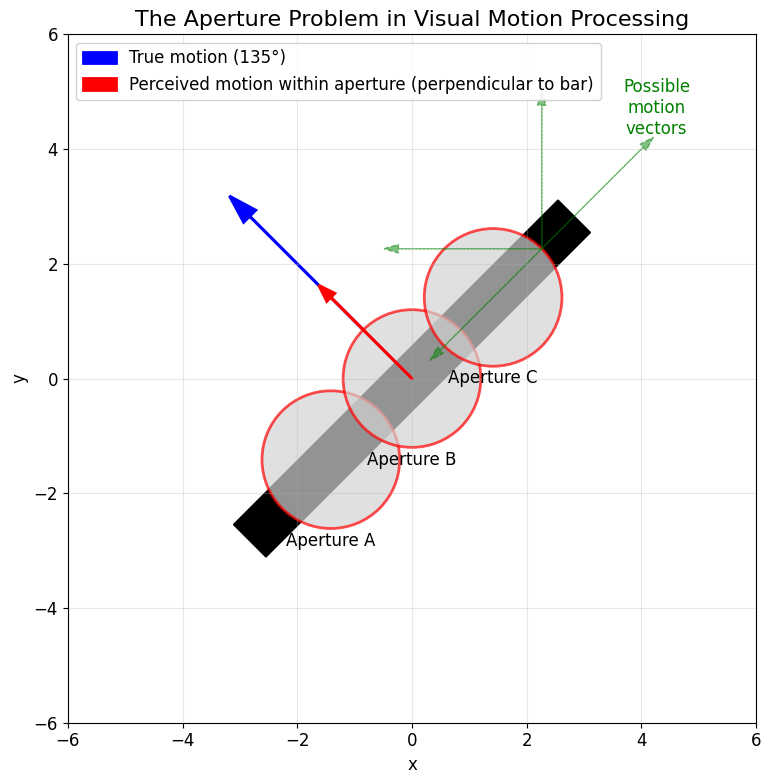

In [3]:
def create_aperture_problem_visualization():
    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Draw a bar (oriented at 45 degrees)
    bar_length = 8
    bar_width = 0.8
    bar_angle = 45  # degrees
    
    # Convert to radians for calculations
    angle_rad = np.deg2rad(bar_angle)
    
    # Bar center position
    center_x, center_y = 0, 0
    
    # Calculate bar endpoints
    dx = (bar_length/2) * np.cos(angle_rad)
    dy = (bar_length/2) * np.sin(angle_rad)
    
    # Create bar vertices
    perp_angle = angle_rad + np.pi/2
    perp_dx = (bar_width/2) * np.cos(perp_angle)
    perp_dy = (bar_width/2) * np.sin(perp_angle)
    
    vertices = [
        (center_x - dx + perp_dx, center_y - dy + perp_dy),
        (center_x + dx + perp_dx, center_y + dy + perp_dy),
        (center_x + dx - perp_dx, center_y + dy - perp_dy),
        (center_x - dx - perp_dx, center_y - dy - perp_dy)
    ]
    
    bar = plt.Polygon(vertices, color='black')
    ax.add_patch(bar)
    
    # Add true motion vector (perpendicular to the bar orientation)
    true_motion_angle = bar_angle + 90  # perpendicular to bar orientation
    true_motion_rad = np.deg2rad(true_motion_angle)
    
    motion_length = 4
    motion_x = motion_length * np.cos(true_motion_rad)
    motion_y = motion_length * np.sin(true_motion_rad)
    
    ax.arrow(center_x, center_y, motion_x, motion_y, 
             head_width=0.3, head_length=0.5, fc='blue', ec='blue', linewidth=2,
             label='True motion (135°)')
    
    # Add component motion (perpendicular to bar within aperture)
    # Create circular apertures at different positions
    aperture_positions = [
        (center_x - dx*0.5, center_y - dy*0.5),
        (center_x, center_y),
        (center_x + dx*0.5, center_y + dy*0.5)
    ]
    
    aperture_radius = 1.2
    aperture_colors = ['lightgray', 'lightgray', 'lightgray']
    
    for i, (ap_x, ap_y) in enumerate(aperture_positions):
        # Draw aperture
        aperture = plt.Circle((ap_x, ap_y), aperture_radius, 
                              fill=True, color=aperture_colors[i], alpha=0.7, 
                              ec='red', linewidth=2)
        ax.add_patch(aperture)
        
        # Perpendicular motion within the aperture
        if i == 1:  # Only draw the arrow for the central aperture
            # Compute perpendicular vector to the bar within the aperture
            perp_angle = angle_rad + np.pi/2
            perp_motion_length = 2
            perp_motion_x = perp_motion_length * np.cos(perp_angle)
            perp_motion_y = perp_motion_length * np.sin(perp_angle)
            
            ax.arrow(ap_x, ap_y, perp_motion_x, perp_motion_y, 
                     head_width=0.2, head_length=0.3, fc='red', ec='red', linewidth=2,
                     label='Perceived motion within aperture (perpendicular to bar)')
    
    # Add labels to show the aperture problem
    ax.text(center_x - dx*0.5, center_y - dy*0.5 - 1.5, 'Aperture A', fontsize=12, ha='center')
    ax.text(center_x, center_y - 1.5, 'Aperture B', fontsize=12, ha='center')
    ax.text(center_x + dx*0.5, center_y + dy*0.5 - 1.5, 'Aperture C', fontsize=12, ha='center')
    
    # Add demonstration of possible motions
    # Draw multiple possible motion vectors that could cause the same local motion
    possible_offsets = np.linspace(-np.pi/2, np.pi/2, 5)
    possible_vectors = []
    
    for offset in possible_offsets:
        possible_angle = perp_angle + offset
        possible_x = 2.5 * np.cos(possible_angle)
        possible_y = 2.5 * np.sin(possible_angle)
        
        # Draw a dashed line indicating a possible motion vector
        if offset != 0:  # Don't redraw the perpendicular one
            arrow = ax.arrow(center_x + dx*0.8, center_y + dy*0.8, possible_x, possible_y, 
                             head_width=0.15, head_length=0.25, fc='green', ec='green', 
                             linewidth=1, alpha=0.5, linestyle='--')
            possible_vectors.append(arrow)
    
    # Add a label for the possible motions
    ax.text(center_x + dx*0.8 + 2, center_y + dy*0.8 + 2, 'Possible\nmotion\nvectors', 
            fontsize=12, color='green', ha='center')
    
    # Set plot limits and appearance
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('y', fontsize=12)
    ax.set_title('The Aperture Problem in Visual Motion Processing', fontsize=16)
    
    # Add a legend
    ax.legend(loc='upper left', framealpha=0.9)
    
    plt.tight_layout()
    plt.show()

create_aperture_problem_visualization()

### Understanding the Aperture Problem

The aperture problem is a fundamental ambiguity in local motion detection:

1. **Local Ambiguity**: When viewing a moving oriented edge through a small aperture (like a V1 receptive field), only the motion component perpendicular to the edge can be directly detected. This is because motion along the edge produces no change in the image within the aperture.

2. **V1 Constraints**: V1 neurons with small receptive fields can only measure the component of motion perpendicular to the edge's orientation. This is shown by the red arrow in the central aperture.

3. **Multiple Possible Motions**: Many different true motion directions (green arrows) could produce the same observed local motion. The true motion could be in any direction that includes the perpendicular component that we can measure.

4. **Integration Required**: Solving the aperture problem requires integrating information across multiple apertures or considering additional constraints. This integration happens in higher visual areas like MT (which we'll explore in the next section).

The aperture problem illustrates why early motion processing in V1 is only the first step in motion perception. Higher-level processing is needed to resolve these ambiguities and accurately perceive the global motion of objects.

## Summary: V1 Motion Processing

In this section, we've explored how neurons in the primary visual cortex (V1) process motion information:

1. **Direction Selectivity**: About 30% of V1 neurons are direction-selective, responding more strongly to motion in one direction than the opposite direction.

2. **Spatiotemporal Receptive Fields**: Direction selectivity arises from inseparable spatiotemporal receptive fields that have a specific tilt or orientation in the space-time domain.

3. **Inseparability Principle**: A spatiotemporal receptive field must be inseparable (cannot be expressed as a simple product of spatial and temporal components) to exhibit direction selectivity.

4. **Aperture Problem**: V1 neurons with small receptive fields can only detect the component of motion perpendicular to an edge, creating ambiguity that must be resolved by higher visual areas.

5. **Bridge to Motion Energy Models**: The spatiotemporal filters we've explored form the foundation for motion energy models, which we'll implement in detail in a later module.

In the next section, we'll examine how the middle temporal area (MT or V5) builds on this V1 motion processing to create a more comprehensive representation of motion in the visual scene.